# 4. Compound clustering

By leveraging the concept of chemical similarity, compound clustering can be a powerful tool for identifying promising candidate molecules for further investigation.

## The principle of similarity

Compounds with similar structures often exhibit comparable biological activity due to their ability to interact with the same receptor sites within the body.
This principle forms the foundation of compound clustering: grouping molecules based on their chemical resemblance.

## Introduction to Clustering Algorithm:

Clustering, the core concept of our project, involves categorizing a collection of objects in a manner that items within the same cluster exhibit a greater level of resemblance to each other than to those in separate clusters. We explore various clustering algorithms such as K-means and density based clustering algorithms

## Butina clustering

In addition to classic clustering algorithm, we delve into Butina clustering, a method that aims to identify smaller but homogeneous clusters. This approach is valuable for creating more focused subsets of compounds with similar characteristics, allowing for more targeted analysis and evaluation.

In [1]:
import time
import random
from pathlib import Path
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
import logging
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import warnings
from sklearn.cluster import KMeans
import hdbscan
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
    AllChem,
    rdMolDescriptors,
)

In [2]:
compound_df = pd.read_csv('data/compounds_lipinski_no_pains.csv',
    index_col=0,
)
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (3311, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
7,CHEMBL3660114,0.20,nM,Cc1ncc(C#Cc2c(C)ncnc2N2CCOC[C@@H]2C)cc1NS(=O)(...,9.698970,<rdkit.Chem.rdchem.Mol object at 0x2b570b84acf0>,463.167811,7,1,2.91414,True
16,CHEMBL3655894,0.28,nM,Cc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1c...,9.552842,<rdkit.Chem.rdchem.Mol object at 0x2b570b84ad60>,449.152161,7,1,2.52564,True
18,CHEMBL3660127,0.30,nM,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.522879,<rdkit.Chem.rdchem.Mol object at 0x2b570b84add0>,499.108103,8,1,2.87922,True
21,CHEMBL3660129,0.39,nM,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.408935,<rdkit.Chem.rdchem.Mol object at 0x2b570b84ae40>,471.103496,9,1,2.28732,True
22,CHEMBL1083912,0.40,nM,CNC(=O)Nc1ccc2c(c1)C(=O)/C(=C\c1c(-c3c(C)nn(C)...,9.397940,<rdkit.Chem.rdchem.Mol object at 0x2b570b84aeb0>,471.190654,6,3,4.56134,True


In [3]:
def convert_smiles_to_molecules(compound_df):
    """Convert SMILES strings to RDKit molecules."""
    molecules = []
    for _, row in compound_df.iterrows():
        try:
            molecule = Chem.MolFromSmiles(row["smiles"])
            molecules.append((molecule, row["molecule_chembl_id"]))
        except Exception as e:
            logging.warning(f"Failed to convert SMILES to molecule: {e}")
    logging.info("Conversion of SMILES to molecules completed.")
    return molecules

In [4]:
# Convert SMILES strings to molecules
molecules = convert_smiles_to_molecules(compound_df)
molecules[:10]

[(<rdkit.Chem.rdchem.Mol at 0x2add57fec120>, 'CHEMBL3660114'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec350>, 'CHEMBL3655894'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec3c0>, 'CHEMBL3660127'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec430>, 'CHEMBL3660129'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec4a0>, 'CHEMBL1083912'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec510>, 'CHEMBL1083305'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec580>, 'CHEMBL4515169'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec5f0>, 'CHEMBL3655855'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec660>, 'CHEMBL3655884'),
 (<rdkit.Chem.rdchem.Mol at 0x2add57fec6d0>, 'CHEMBL3660101')]

In [5]:
def generate_fingerprints(molecules):
    """Generate fingerprints for molecules."""
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, _ in molecules]
    logging.info("Fingerprints generated for molecules.")
    return fingerprints

In [6]:
# Generate fingerprints for molecules
fingerprints = generate_fingerprints(molecules)

In [7]:
# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 3311
Fingerprint length per compound: 2048


## Bunita Clustering

In [8]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = []
        for j in range(i):
            similarity = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
            similarities.append(1 - similarity)  # Convert similarity to distance
        dissimilarity_matrix.extend(similarities)
    return dissimilarity_matrix

In [9]:
def cluster_fingerprints_butina(fingerprints, cutoff=0.1):
    """Cluster fingerprints using Butina algorithm"""
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [10]:
# Run clustering procedures for the dataset
clusters_butina = cluster_fingerprints_butina(fingerprints, cutoff=0.1)

In [11]:
# Compare the performance of both clustering algorithms
num_clusters_butina = len(clusters_butina)

print("Number of clusters (Butina):", num_clusters_butina)

Number of clusters (Butina): 1406


In [12]:
# Visualize example clusters
def visualize_clusters(molecules, clusters, num_clusters=5):
    for i in range(num_clusters):
        cluster_size = len(clusters[i])
        print(f"Cluster {i+1} Size: {cluster_size}")
        Draw.MolsToGridImage([molecules[idx][0] for idx in clusters[i]], legends=[molecules[idx][1] for idx in clusters[i]], molsPerRow=min(5, cluster_size), subImgSize=(300, 300))

# Visualize example clusters for Butina
print("Example Clusters for Butina Clustering:")
visualize_clusters(molecules, clusters_butina)

Example Clusters for Butina Clustering:
Cluster 1 Size: 118
Cluster 2 Size: 43
Cluster 3 Size: 30
Cluster 4 Size: 29
Cluster 5 Size: 29


/home/kanku.d/.local/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


In [13]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
def visualize_clusters_pca(molecules, clusters, num_clusters=5):
    # Create a PCA object to reduce the dimensionality of the fingerprints to 2 dimensions
    pca = PCA(n_components=2)
    
    for i in range(num_clusters):
        cluster_size = len(clusters[i])
        print(f"Cluster {i+1} Size: {cluster_size}")
        # Extract fingerprints for compounds in the cluster
        cluster_fps = [rdkit_gen.GetFingerprint(molecules[idx][0]) for idx in clusters[i]]
        # Reduce dimensionality using PCA
        reduced_fps = pca.fit_transform(cluster_fps)
        # Plot the compounds in the cluster
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_fps[:, 0], reduced_fps[:, 1], label=f"Cluster {i+1}")
        plt.title(f"Cluster {i+1} Visualization")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend()
        plt.show()

Example Clusters for Butina Clustering:
Cluster 1 Size: 118


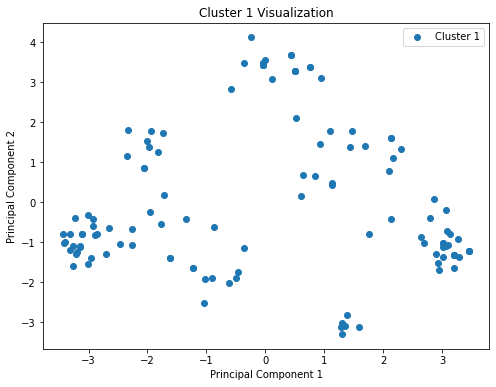

Cluster 2 Size: 43


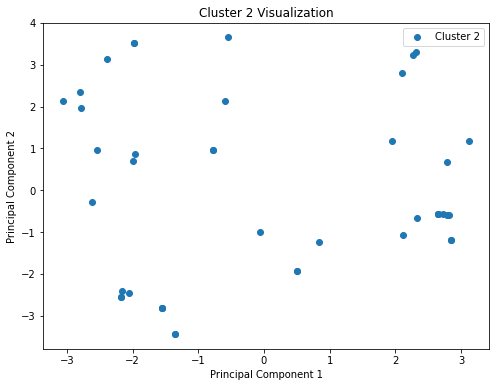

Cluster 3 Size: 30


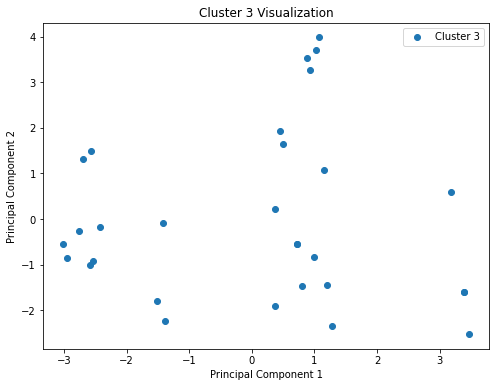

Cluster 4 Size: 29


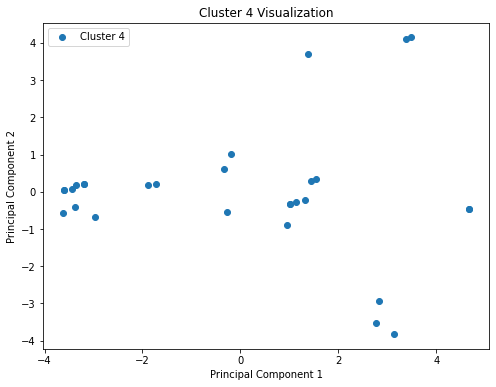

Cluster 5 Size: 29


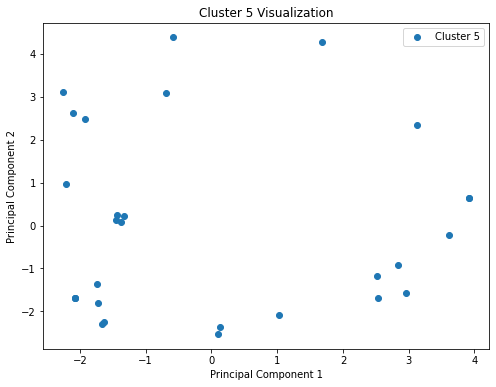

In [14]:
# Visualize example clusters for Butina using PCA
print("Example Clusters for Butina Clustering:")
visualize_clusters_pca(molecules, clusters_butina)

Ten molecules from largest cluster:


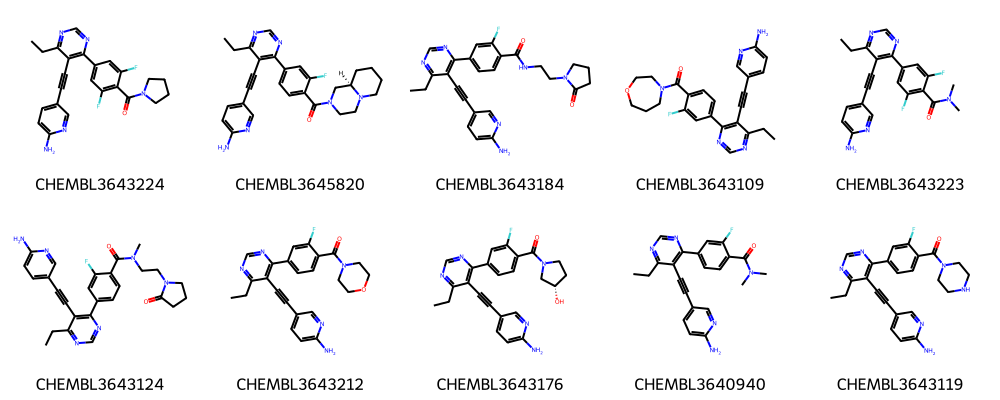

In [15]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [molecules[i][0] for i in clusters_butina[0][:10]],
    legends=[molecules[i][1] for i in clusters_butina[0][:10]],
    molsPerRow=5,
)

In [16]:
# Save molecules from largest cluster
sdf_path = str("data/molecule_set_largest_cluster_butina.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters_butina[0]:
    mol, label = molecules[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

In [17]:
# Generate image
img = Draw.MolsToGridImage(
    [molecules[clusters_butina[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.data.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("cluster_representatives.svg", "w") as f:
    f.write(molsvg)

In [18]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [19]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters_butina[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(molecules[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

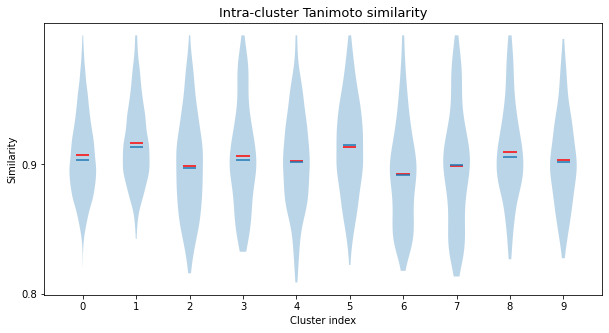

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")

By looking at this plot, we can assess the distribution of Tanimoto similarity scores within each cluster. High mean indicated by the red line or high median similarity scores suggest that the molecules within the cluster are more similar to each other.This information can be valuable for understanding the homogeneity of clusters and the quality of the clustering algorithm used.

In [21]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [molecules[c[0]] for c in clusters_butina]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))

Number of cluster centers: 1406


In [22]:

# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters_butina:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(molecules[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [23]:
def compute_diversity(cluster_compounds):
    # Compute fingerprints for all compounds in the cluster
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(compound[0], 2, nBits=1024) for compound in cluster_compounds]
    
    # Calculate pairwise Tanimoto similarity between fingerprints
    diversity_scores = []
    for i in range(len(fingerprints)):
        similarity_sum = 0.0
        for j in range(len(fingerprints)):
            if i != j:
                similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
                similarity_sum += similarity
        # Calculate average similarity as diversity score
        diversity_score = similarity_sum / (len(fingerprints) - 1)
        diversity_scores.append(diversity_score)
    
    return diversity_scores

In [24]:
def sort_compounds_by_score(cluster_compounds, diversity_scores):
    """Sort molecules within the cluster based on diversity scores."""
    sorted_compounds = [compound for _, compound in sorted(zip(diversity_scores, cluster_compounds), key=lambda x: x[0], reverse=True)]
    return sorted_compounds

def select_representative_compounds(sorted_cluster, num_representatives=10):
    """Select a representative subset of molecules from the sorted cluster."""
    return sorted_cluster[:num_representatives]

In [25]:
def select_representative_molecules(compounds, clusters, num_max_molecules=1000):
    selected_molecules = []
    for cluster in clusters:
        cluster_compounds = [compounds[i] for i in cluster]
        diversity_scores = compute_diversity(cluster_compounds)
        sorted_cluster = sort_compounds_by_score(cluster_compounds, diversity_scores)
        selected_compounds = select_representative_compounds(sorted_cluster)
        selected_molecules += selected_compounds
        if len(selected_molecules) >= num_max_molecules:
            break
    return selected_molecules

In [26]:
selected_molecules = select_representative_molecules(molecules, clusters_butina, num_max_molecules=1000)
print("Number of selected molecules:",len(selected_molecules))

Number of selected molecules: 1001


In [27]:
# Function to evaluate clustering quality using silhouette score
def evaluate_clustering_quality(compounds, clusters):
    compound_features = [rdkit_gen.GetFingerprint(comp[0]) for comp in compounds]
    cluster_labels = [label for label, cluster in enumerate(clusters) for _ in cluster]
    silhouette_average = silhouette_score(compound_features, cluster_labels)
    print(f"Silhouette Score: {silhouette_average}")

In [28]:
# Evaluate clustering quality
evaluate_clustering_quality(molecules, clusters_butina)

Silhouette Score: -0.3902886801629674


## Virtual screening using clusters from algorithm

In [29]:
indices_first_cluster = clusters_butina[0]

# Retrieve the molecules in the first cluster
molecules_first_cluster = [molecules[idx] for idx in indices_first_cluster]

# Create a list to store the properties of molecules in the first cluster
molecules_first_cluster_data = []

# Extract the properties of each molecule in the first cluster
for idx, (molecule, molecule_id) in enumerate(molecules_first_cluster):
    # For example, you can extract the SMILES string from the molecule if available
    smiles = Chem.MolToSmiles(molecule) if molecule is not None else None
    
    # Append the properties to the list
    molecules_first_cluster_data.append({
        "Molecule_ID": molecule_id,
        "SMILES": smiles
    })

# Convert the list of molecule properties into a DataFrame
molecules_first_cluster_df = pd.DataFrame(molecules_first_cluster_data)

# Display the DataFrame
molecules_first_cluster_df.head()

,Molecule_ID,SMILES
0,CHEMBL3643224,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...
1,CHEMBL3645820,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...
2,CHEMBL3643184,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...
3,CHEMBL3643109,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...
4,CHEMBL3643223,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...


In [30]:
# Merge the dataframes on molecule IDs to get pIC50 values for molecules in the first cluster
molecules_butina_cluster_df = pd.merge(molecules_first_cluster_df, compound_df, left_on="Molecule_ID", right_on="molecule_chembl_id", how="left")

# Drop the redundant "molecule_chembl_id" column
molecules_butina_cluster_df.drop(columns=["molecule_chembl_id"], inplace=True)

print(f"Number of molecules in dataset: {len(molecules_butina_cluster_df)}")
# Display the DataFrame
molecules_butina_cluster_df.head()

Number of molecules in dataset: 118


,Molecule_ID,SMILES,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL3643224,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,124.80,nM,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,6.903785,<rdkit.Chem.rdchem.Mol object at 0x2b570b9304a0>,433.171417,5,1,3.5972,True
1,CHEMBL3645820,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,45.78,nM,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,7.339324,<rdkit.Chem.rdchem.Mol object at 0x2b570b801820>,484.238688,6,1,3.5324,True
2,CHEMBL3643184,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,46.00,nM,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,7.337242,<rdkit.Chem.rdchem.Mol object at 0x2b570b801ba0>,472.202302,6,2,2.5743,True
3,CHEMBL3643109,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,49.00,nM,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,7.309804,<rdkit.Chem.rdchem.Mol object at 0x2b570b7fb820>,445.191403,6,1,3.0846,True
4,CHEMBL3643223,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,49.06,nM,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,7.309272,<rdkit.Chem.rdchem.Mol object at 0x2b570b7fbb30>,407.155767,5,1,3.0630,True


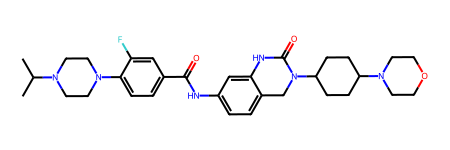

In [31]:
query = Chem.MolFromSmiles("CC(C)N1CCN(CC1)c2ccc(cc2F)C(=O)Nc3ccc4c(c3)NC(=O)N(C4)C5CCC(CC5)N6CCOCC6")
query

In [32]:
# Generate MACCS keys fingerprint
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)

# Generate circular (Morgan) fingerprint
circular_fp_query = rdMolDescriptors.GetMorganFingerprintAsBitVect(query, 2, nBits=1024)

In [34]:
# Define a function to generate Morgan fingerprints
def generate_morgan_fingerprint(mol):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)


# Apply the function to generate Morgan fingerprints for each molecule
molecules_butina_cluster_df['morgan'] = molecules_butina_cluster_df['ROMol'].apply(generate_morgan_fingerprint)
molecules_butina_cluster_df.head()

,Molecule_ID,SMILES,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,morgan
0,CHEMBL3643224,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,124.80,nM,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,6.903785,<rdkit.Chem.rdchem.Mol object at 0x2add62b2f2e0>,433.171417,5,1,3.5972,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3645820,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,45.78,nM,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,7.339324,<rdkit.Chem.rdchem.Mol object at 0x2add58aeaf20>,484.238688,6,1,3.5324,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3643184,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,46.00,nM,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,7.337242,<rdkit.Chem.rdchem.Mol object at 0x2add58a93430>,472.202302,6,2,2.5743,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL3643109,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,49.00,nM,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,7.309804,<rdkit.Chem.rdchem.Mol object at 0x2add58a93190>,445.191403,6,1,3.0846,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3643223,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,49.06,nM,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,7.309272,<rdkit.Chem.rdchem.Mol object at 0x2add58a933c0>,407.155767,5,1,3.0630,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [35]:
PandasTools.AddMoleculeColumnToFrame(molecules_butina_cluster_df, "smiles")
circular_fp_list = molecules_butina_cluster_df["ROMol"].apply(generate_morgan_fingerprint).tolist()
maccs_fp_list = molecules_butina_cluster_df["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

In [36]:
molecules_butina_cluster_df["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecules_butina_cluster_df["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

In [37]:
molecules_butina_cluster_df["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecules_butina_cluster_df["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [38]:
molecules_butina_cluster_df[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]
].head()

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,0.573333,0.132231,0.728814,0.233577
1,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,0.643836,0.132231,0.783333,0.233577
2,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,0.675325,0.132231,0.806202,0.233577
3,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,0.666667,0.132231,0.800000,0.233577
4,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,0.506667,0.132231,0.672566,0.233577


In [39]:
molecules_butina_cluster_df.head()

,Molecule_ID,SMILES,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,morgan,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL3643224,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,124.80,nM,CCc1ncnc(-c2cc(F)c(C(=O)N3CCCC3)c(F)c2)c1C#Cc1...,6.903785,<rdkit.Chem.rdchem.Mol object at 0x2add58aeac80>,433.171417,5,1,3.5972,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.573333,0.132231,0.728814,0.233577
1,CHEMBL3645820,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,45.78,nM,CCc1ncnc(-c2ccc(C(=O)N3CCN4CCCC[C@@H]4C3)c(F)c...,7.339324,<rdkit.Chem.rdchem.Mol object at 0x2add58aeaba0>,484.238688,6,1,3.5324,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.643836,0.132231,0.783333,0.233577
2,CHEMBL3643184,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,46.00,nM,CCc1ncnc(-c2ccc(C(=O)NCCN3CCCC3=O)c(F)c2)c1C#C...,7.337242,<rdkit.Chem.rdchem.Mol object at 0x2add58a8a040>,472.202302,6,2,2.5743,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.675325,0.132231,0.806202,0.233577
3,CHEMBL3643109,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,49.00,nM,CCc1ncnc(-c2ccc(C(=O)N3CCCOCC3)c(F)c2)c1C#Cc1c...,7.309804,<rdkit.Chem.rdchem.Mol object at 0x2add58a8a0b0>,445.191403,6,1,3.0846,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.666667,0.132231,0.800000,0.233577
4,CHEMBL3643223,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,49.06,nM,CCc1ncnc(-c2cc(F)c(C(=O)N(C)C)c(F)c2)c1C#Cc1cc...,7.309272,<rdkit.Chem.rdchem.Mol object at 0x2add58a8a120>,407.155767,5,1,3.0630,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.506667,0.132231,0.672566,0.233577


## distribution of similarity values

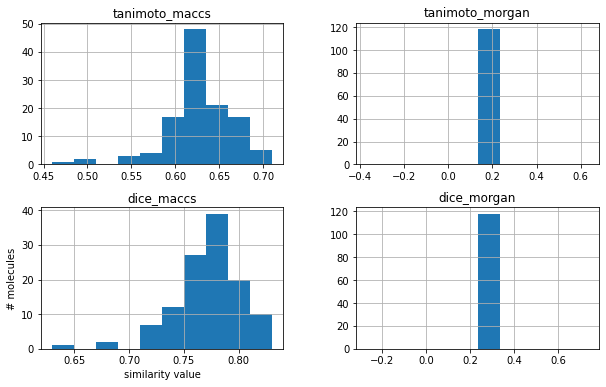

In [40]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecules_butina_cluster_df.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecules_butina_cluster_df.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecules_butina_cluster_df.hist(["dice_maccs"], ax=axes[1, 0])
molecules_butina_cluster_df.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

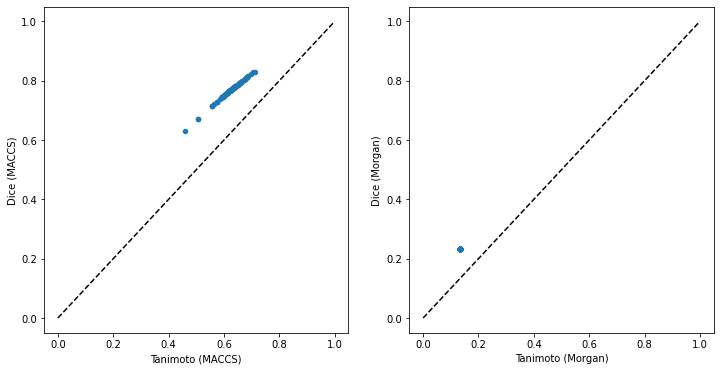

In [41]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

molecules_butina_cluster_df.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

molecules_butina_cluster_df.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

In [42]:
molecules_butina_cluster_df.sort_values(["dice_maccs"], ascending=False).head()

,Molecule_ID,SMILES,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,morgan,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
54,CHEMBL3645958,CCc1ncnc(-c2ccc(C(=O)N3CCN(C(C)CO)CC3)c(F)c2)c...,212.0,nM,CCc1ncnc(-c2ccc(C(=O)N3CCN(C(C)CO)CC3)c(F)c2)c...,6.673664,<rdkit.Chem.rdchem.Mol object at 0x2add58a91740>,488.233602,7,2,2.3607,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.710526,0.132231,0.830769,0.233577
25,CHEMBL3643138,CCc1ncnc(-c2ccc(C(=O)N3CCN(C)C(=O)C3)c(F)c2)c1...,115.0,nM,CCc1ncnc(-c2ccc(C(=O)N3CCN(C)C(=O)C3)c(F)c2)c1...,6.939302,<rdkit.Chem.rdchem.Mol object at 0x2add58a8aa50>,458.186652,6,1,2.1363,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.706667,0.132231,0.828125,0.233577
12,CHEMBL3643116,CCc1ncnc(-c2ccc(C(=O)N3CCCC(O)C3)c(F)c2)c1C#Cc...,64.0,nM,CCc1ncnc(-c2ccc(C(=O)N3CCCC(O)C3)c(F)c2)c1C#Cc...,7.193820,<rdkit.Chem.rdchem.Mol object at 0x2add58a8a4a0>,445.191403,6,2,2.8190,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.697368,0.132231,0.821705,0.233577
27,CHEMBL3645962,CCc1ncnc(-c2ccc(C(=O)N3CCN(CC(C)O)CC3)c(F)c2)c...,121.5,nM,CCc1ncnc(-c2ccc(C(=O)N3CCN(CC(C)O)CC3)c(F)c2)c...,6.915424,<rdkit.Chem.rdchem.Mol object at 0x2add58a8ab30>,488.233602,7,2,2.3607,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.688312,0.132231,0.815385,0.233577
59,CHEMBL3643129,CCc1ncnc(-c2ccc(C(=O)N3CCC(O)(C(C)C)CC3)c(F)c2...,228.0,nM,CCc1ncnc(-c2ccc(C(=O)N3CCC(O)(C(C)C)CC3)c(F)c2...,6.642065,<rdkit.Chem.rdchem.Mol object at 0x2add58a91970>,487.238353,6,2,3.8452,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.687500,0.132231,0.814815,0.233577


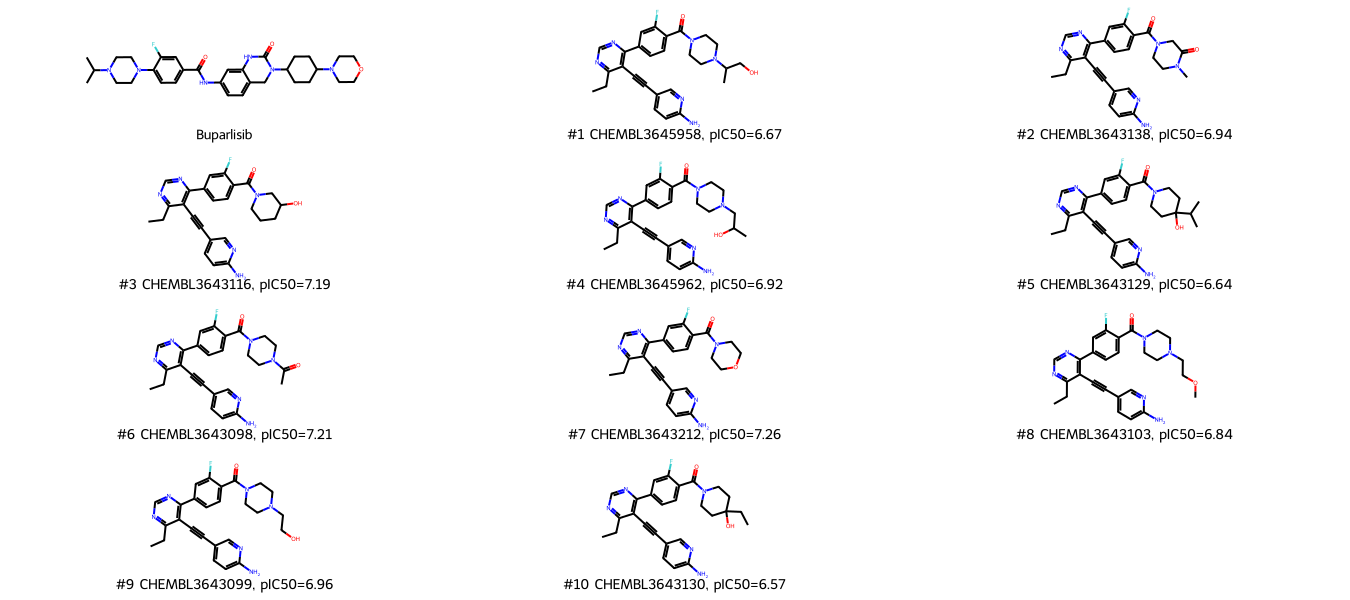

In [43]:
top_n_molecules = 10
top_molecules = molecules_butina_cluster_df.sort_values(["dice_maccs"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['Molecule_ID']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Buparlisib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

## Enrichment Plots

In [44]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules with similarity values to a query molecule.
    similarity_measure : str
        Column name which will be used to sort the DataFrame．
    pic50_cutoff : float
        pIC50 cutoff value used to discriminate active and inactive molecules.

    Returns
    -------
    pandas.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)
    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

In [45]:
pic50_cutoff = 6.3

In [46]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan","dice_maccs","dice_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecules_butina_cluster_df, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}
enrichment_data["dice_maccs"].head()

,% ranked dataset,% true actives identified
0,0.008475,0.009259
1,0.016949,0.018519
2,0.025424,0.027778
3,0.033898,0.037037
4,0.042373,0.046296


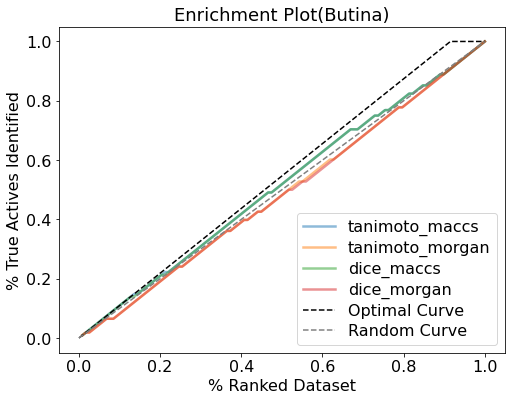

In [47]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set fontsize
fontsize = 16

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=2.5,
    )

# Set labels and title
ax.set_ylabel("% True Actives Identified", size=fontsize)
ax.set_xlabel("% Ranked Dataset", size=fontsize)
ax.set_title("Enrichment Plot(Butina)", size=fontsize+2)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecules_butina_cluster_df["pIC50"] >= pic50_cutoff) / len(molecules_butina_cluster_df)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal Curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random Curve", color="grey", linestyle="--")

# Set ticks and legend
plt.tick_params(labelsize=fontsize)
plt.legend(
    loc="lower right",
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot with high resolution
plt.savefig(
    "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

# Show plot
plt.show()

In [48]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

In [49]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

In [50]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

In [51]:
ranked_dataset_percentage_cutoff = 5

In [52]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 4.6%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 3.7%
Experimental EF for 5% of ranked dataset (dice_maccs): 4.6%
Experimental EF for 5% of ranked dataset (dice_morgan): 3.7%
